In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [1]:
from imports import *

## Image creation

In [2]:
# Load the matrices from CSV files into separate variables
file_names = ["v1202_pematrix_TPCselection", "v1202_timematrix_TPCselection_c1_10ophits", "vis_map_realistic", "vuv_map_realistic", "coated_pmt_map_realistic", "uncoated_pmt_map_realistic" ,"xarap_vis_map_realistic" , "xarap_vuv_map_realistic", "vis_map_compressed", "vuv_map_compressed", "coated_pmt_map_compressed", "uncoated_pmt_map_compressed", "xarap_vis_map_compressed", "xarap_vuv_map_compressed"]

for i, name in enumerate(file_names):
    if i < 2:  # The first two files as float
        locals()[name] = np.loadtxt(f"saved_archives/pe_matrix_&_time_matrix/{name}.csv", delimiter=",")
    elif 2 <= i < 8:  # The next two files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/realistic/{name}.csv", delimiter=",", dtype=int)
    else:  # The remaining files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/compressed/{name}.csv", delimiter=",", dtype=int)

In [10]:
# Load the matrices from CSV files into separate variables
file_names = ["v1202_pematrix_noTPCselection", "v1202_timematrix_noTPCselection_c1_10ophits", "vis_map_realistic", "vuv_map_realistic", "coated_pmt_map_realistic", "uncoated_pmt_map_realistic" ,"xarap_vis_map_realistic" , "xarap_vuv_map_realistic", "vis_map_compressed", "vuv_map_compressed", "coated_pmt_map_compressed", "uncoated_pmt_map_compressed", "xarap_vis_map_compressed", "xarap_vuv_map_compressed"]

for i, name in enumerate(file_names):
    if i < 2:  # The first two files as float
        locals()[name] = np.loadtxt(f"saved_archives/pe_matrix_&_time_matrix/{name}.csv", delimiter=",")
    elif 2 <= i < 8:  # The next two files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/realistic/{name}.csv", delimiter=",", dtype=int)
    else:  # The remaining files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/compressed/{name}.csv", delimiter=",", dtype=int)

### Map creation

In [3]:
image_realistic= image_creator_gen_inv_nuevo2(v1202_pematrix_TPCselection, v1202_timematrix_TPCselection_c1_10ophits, coated_pmt_map_realistic, uncoated_pmt_map_realistic, xarap_vis_map_realistic, xarap_vuv_map_realistic)
print('Number of events, image height, width, layers:', np.shape(image_realistic))

Number of events, image height, width, layers: (21964, 59, 70, 8)


In [31]:
np.save("/data/vidales/images/v1202_TPCselection_c1_10ophits_inv.npy", image_realistic)

In [11]:
image_realistic_noTPC= image_creator_gen_inv(v1202_pematrix_noTPCselection, v1202_timematrix_noTPCselection_c1_10ophits, coated_pmt_map_realistic, uncoated_pmt_map_realistic, xarap_vis_map_realistic, xarap_vuv_map_realistic)
print('Number of events, image height, width, layers:', np.shape(image_realistic))

Number of events, image height, width, layers: (21964, 59, 70, 8)


In [ ]:
pe_image_inv, time_image_inv= image_creator_gen_2images_inv(v1202_pematrix_noTPCselection, v1202_timematrix_noTPCselection_c1_10ophits, coated_pmt_map_realistic, uncoated_pmt_map_realistic, xarap_vis_map_realistic, xarap_vuv_map_realistic)
print('Number of events, image height, width, layers:', np.shape(image_realistic_inv))

In [6]:
np.save("/data/vidales/images/v1202_noTPCselection_c1_10ophits_pe_image_inv.npy", pe_image_inv)
np.save("/data/vidales/images/v1202_noTPCselection_c1_10ophits_time_image_inv.npy", time_image_inv)

In [3]:
pe_image_realistic_4comp, time_image_realistic_4comp = image_creator_gen2(pe_matrix_v0302, time_matrix_50_v0302, coated_pmt_map_realistic, uncoated_pmt_map_realistic, xarap_vis_map_realistic, xarap_vuv_map_realistic)
print('Number of events, image height, width, layers:', np.shape(pe_image_realistic_4comp))

Number of events, image height, width, layers: (21796, 59, 70, 8)


In [5]:
np.save("/data/vidales/images/pe_image_realistic_4comp_v0402_sin_inv.npy", pe_image_realistic_4comp)
np.save("/data/vidales/images/time_image_realistic_4comp_v0402.npy_sin_inv", time_image_realistic_4comp)

### Alberto image generation

In [2]:
# Load the matrices from CSV files into separate variables
file_names = ["pe_matrix_corrected", "time_matrix_corrected", "alberto_vis_map", "alberto_vuv_map"]

for i, name in enumerate(file_names):
    if i < 2:  # The first two files as float
        locals()[name] = np.loadtxt(f"saved_archives/pe_matrix_&_time_matrix/{name}.csv", delimiter=",")
    else:  # The next two files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/Alberto_maps/{name}.csv", delimiter=",", dtype=int)

In [3]:
alberto_image_corrected = alberto_image(pe_matrix_corrected, time_matrix_corrected, alberto_vis_map, alberto_vuv_map)

In [4]:
np.save("/data/vidales/images/alberto_image_corrected.npy", alberto_image_corrected)

## Visualization of generated images

### 4-component visualization

**load data**

In [3]:
image_realistic = np.load("/data/vidales/images/image_realistic_4comp_c_1_first10_2101.npy")

In [5]:
image_realistic_2images = np.concatenate((pe_image_realistic_4comp, time_image_realistic_4comp), axis=-1)
print('Number of events, image height, width, layers:', np.shape(image_realistic_2images))

Number of events, image height, width, layers: (21796, 59, 70, 16)


**Si tiene 16 capas de imagen por evento**

In [31]:
"""labels_2images = [
        "PE1: Coated PMT/Volume -", "PE2: Coated PMT/Volume +", "PE1: Uncoated PMT/Volume -", "PE2: Uncoated PMT/Volume +",
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +",
        "T1: Coated PMT/Volume -", "T2: Coated PMT/Volume +", "T1: Uncoated PMT/Volume -", "T2: Uncoated PMT/Volume +", 
        "T1: XA VIS/Volume -", "T2: XA VIS/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"   
    ]"""


labels = [
        "PE1: Coated PMT/Volume -", "PE2: Coated PMT/Volume +", "T1: Coated PMT/Volume -", "T2: Coated PMT/Volume +",
        "PE1: Uncoated PMT/Volume -", "PE2: Uncoated PMT/Volume +", "T1: Uncoated PMT/Volume -", "T2: Uncoated PMT/Volume +",
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "T1: XA VIS/Volume -", "T2: XA VIS/Volume +",
        "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"   
    ]


groups = [
        [0, 1, 4, 5],    # First group
        [2, 3, 6, 7],    # Second group
        [8, 9, 12, 13],  # Third group
        [10, 11, 14, 15] # Fourth group
    ]

grid =(4,4)
event_idx=1243

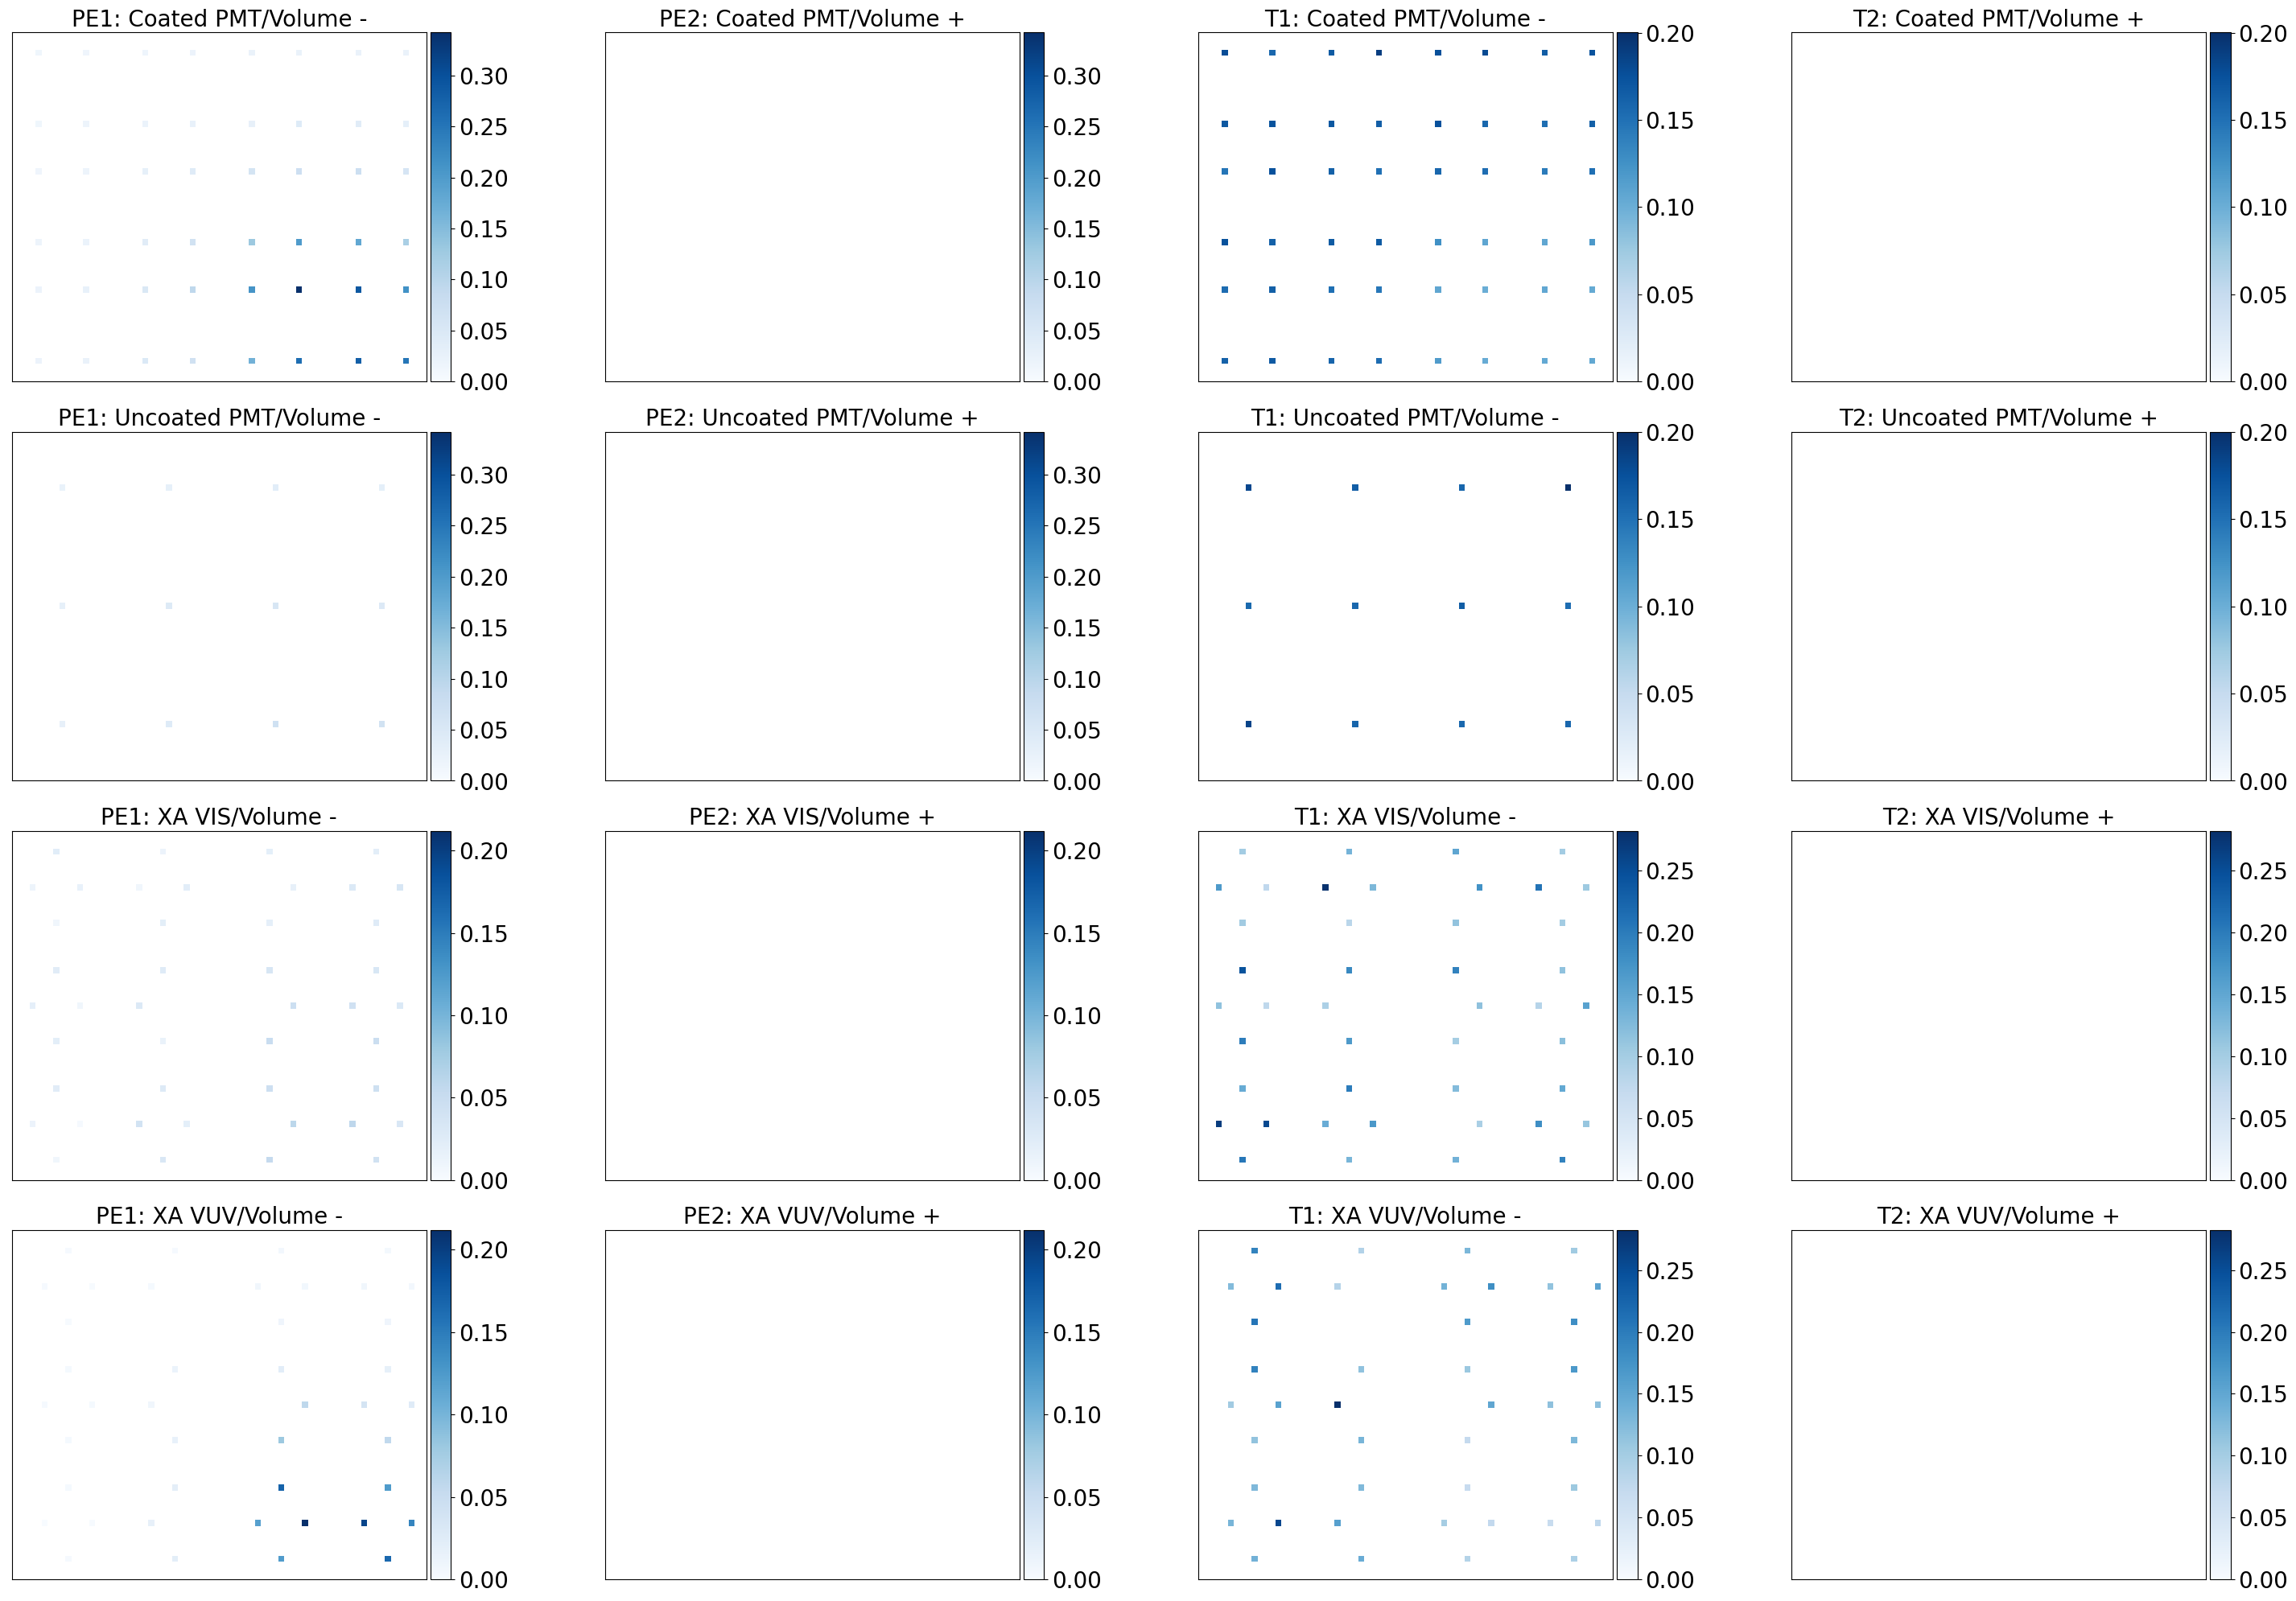

In [32]:
plot_image(image_realistic, event_idx, labels, groups, grid, figsize=(30, 20), show_colorbar= True)

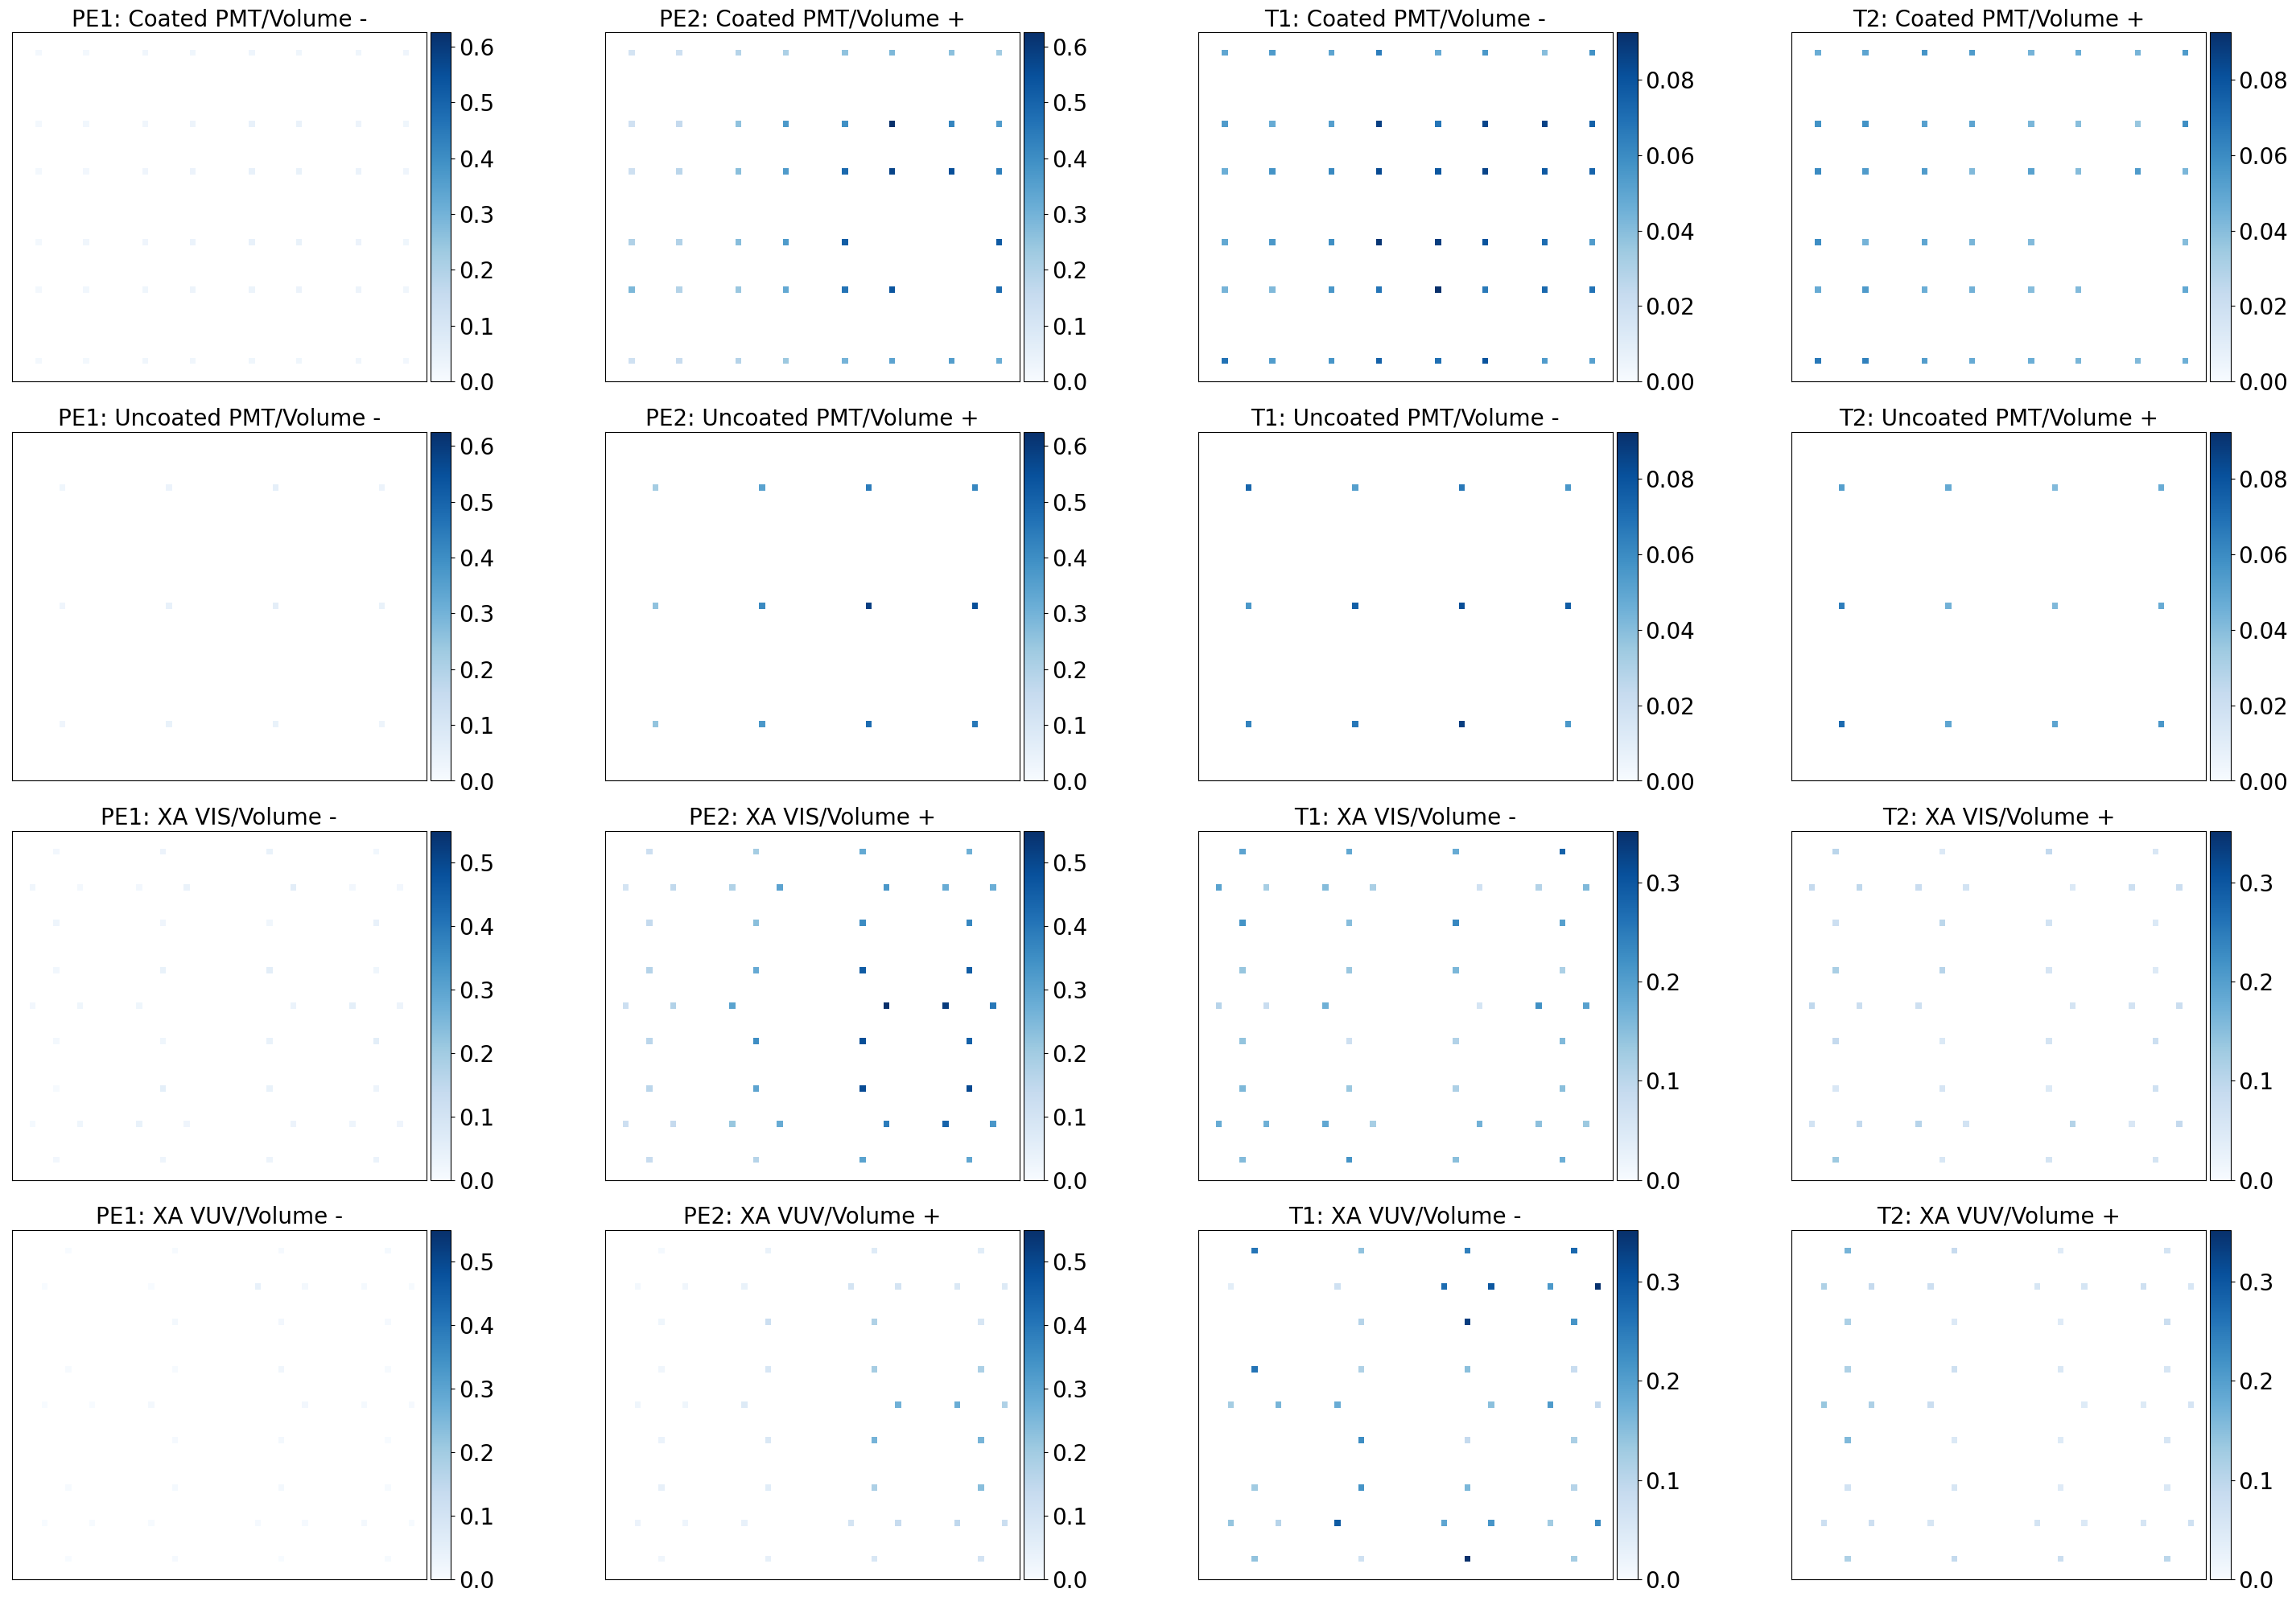

In [26]:
plot_image(image_realistic_10, event_idx, labels, groups, grid, figsize=(30, 20), show_colorbar= True)

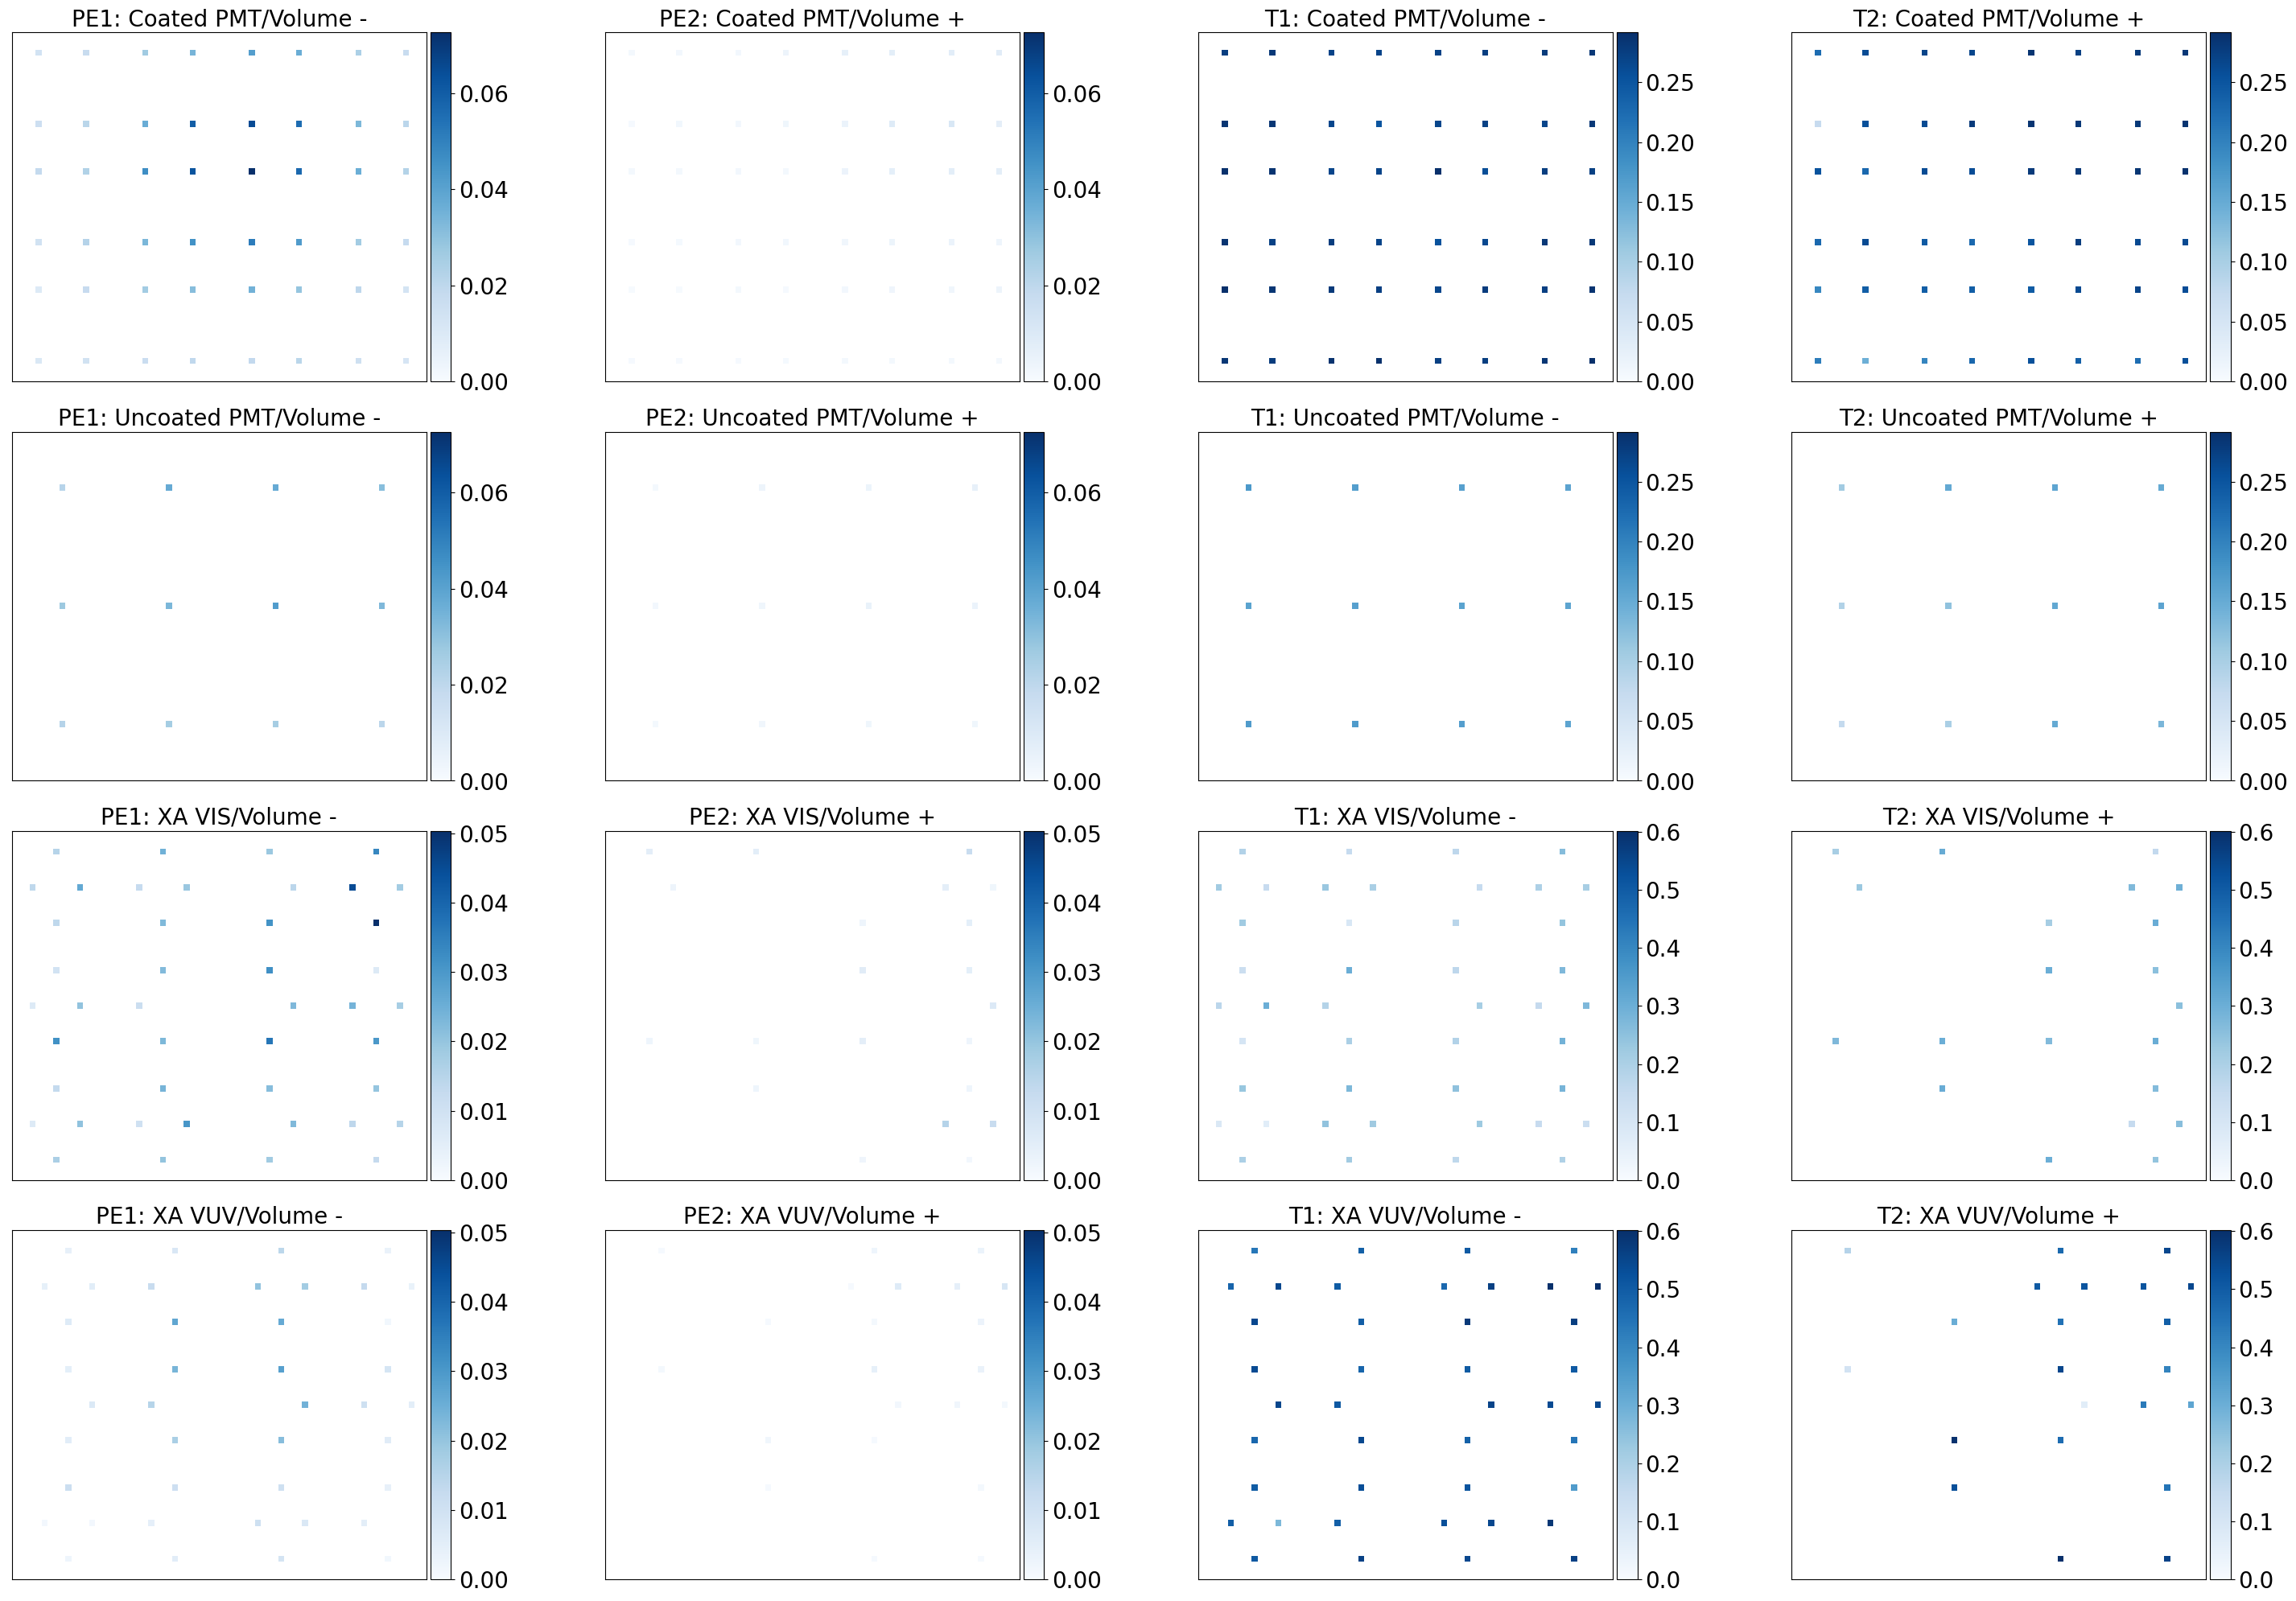

In [40]:
plot_image(image_realistic_inv, event_idx, labels, groups, grid, figsize=(30, 20), show_colorbar= True)

In [4]:
"""labels_2images = [
        "PE1: Coated PMT/Volume -", "PE2: Coated PMT/Volume +", "PE1: Uncoated PMT/Volume -", "PE2: Uncoated PMT/Volume +",
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +",
        "T1: Coated PMT/Volume -", "T2: Coated PMT/Volume +", "T1: Uncoated PMT/Volume -", "T2: Uncoated PMT/Volume +", 
        "T1: XA VIS/Volume -", "T2: XA VIS/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"   
    ]"""


labels = [
        "PE1: Coated PMT/Volume -", "PE2: Coated PMT/Volume +", "T1: Coated PMT/Volume -", "T2: Coated PMT/Volume +",
        "PE1: Uncoated PMT/Volume -", "PE2: Uncoated PMT/Volume +", "T1: Uncoated PMT/Volume -", "T2: Uncoated PMT/Volume +",
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "T1: XA VIS/Volume -", "T2: XA VIS/Volume +",
        "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"   
    ]


groups = [
        [0, 1, 4, 5],    # First group
        [2, 3, 6, 7],    # Second group
        [8, 9, 12, 13],  # Third group
        [10, 11, 14, 15] # Fourth group
    ]

grid =(4,4)
event_idx=1892

In [5]:
plot_image(image_realistic_noTPC, event_idx, labels, groups, grid, figsize=(30, 20), show_colorbar= True)

NameError: name 'image_realistic_noTPC' is not defined

**Si tiene ocho capas de imagen**

In [29]:
labels_pmts = [
        "PE1: Coated PMT", "PE2: Uncoated PMT", "T1: Coated PMT", "T2: Uncoated PMT",
        "PE3: XAs VIS", "PE4: XAs VUV","T1: XAs VIS", "T2: XAs VUV"
    ]
    
groups_pmts = [
        [0, 1], [2, 3],    # First group
        [4, 5], [6, 7]   # Second group
    ]

grid_pmts =(2,4)
event_idx=1893

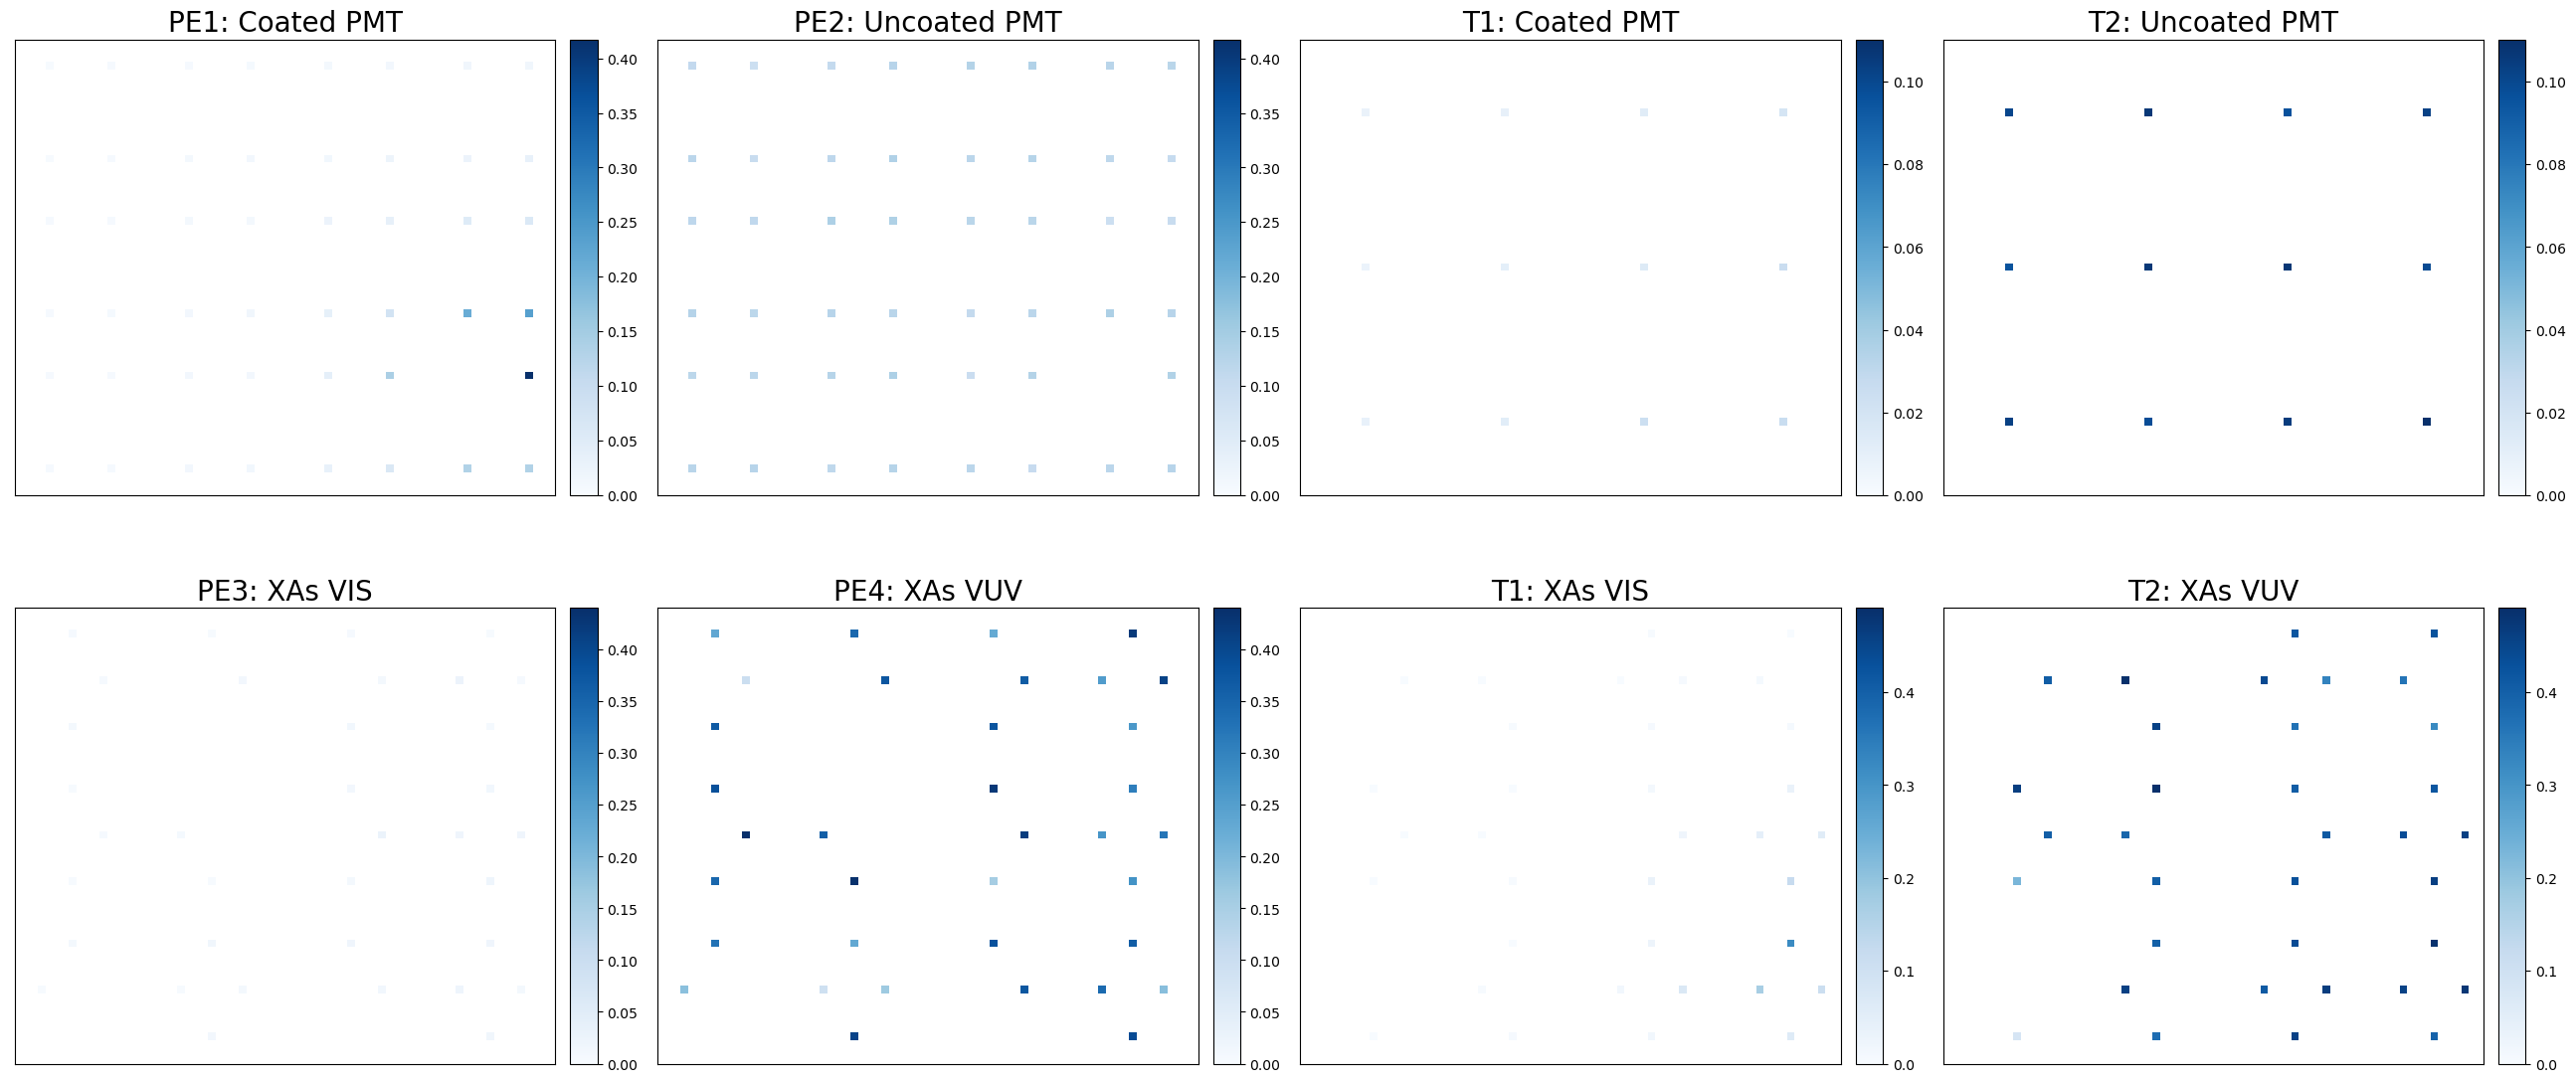

In [30]:
plot_image2(image_realistic, event_idx, labels_pmts, groups_pmts, grid_pmts, figsize=(26, 12))

In [83]:
print(np.unique(image_realistic_4comp_2[1497]))

[0.]


In [6]:
labels_xas = [
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "T1: XA VIS/Volume -", "T2: XA VIS/Volume +", 
        "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"
    ]
    
groups_xas = [
        [0, 1, 4, 5],  # Third group
        [2, 3, 6, 7] # Fourth group
    ]

grid_xas =(2,4)
event_idx=590

In [9]:
image_compressed_4comp = np.load("/data/vidales/images/image_compressed_4comp_1411.npy")

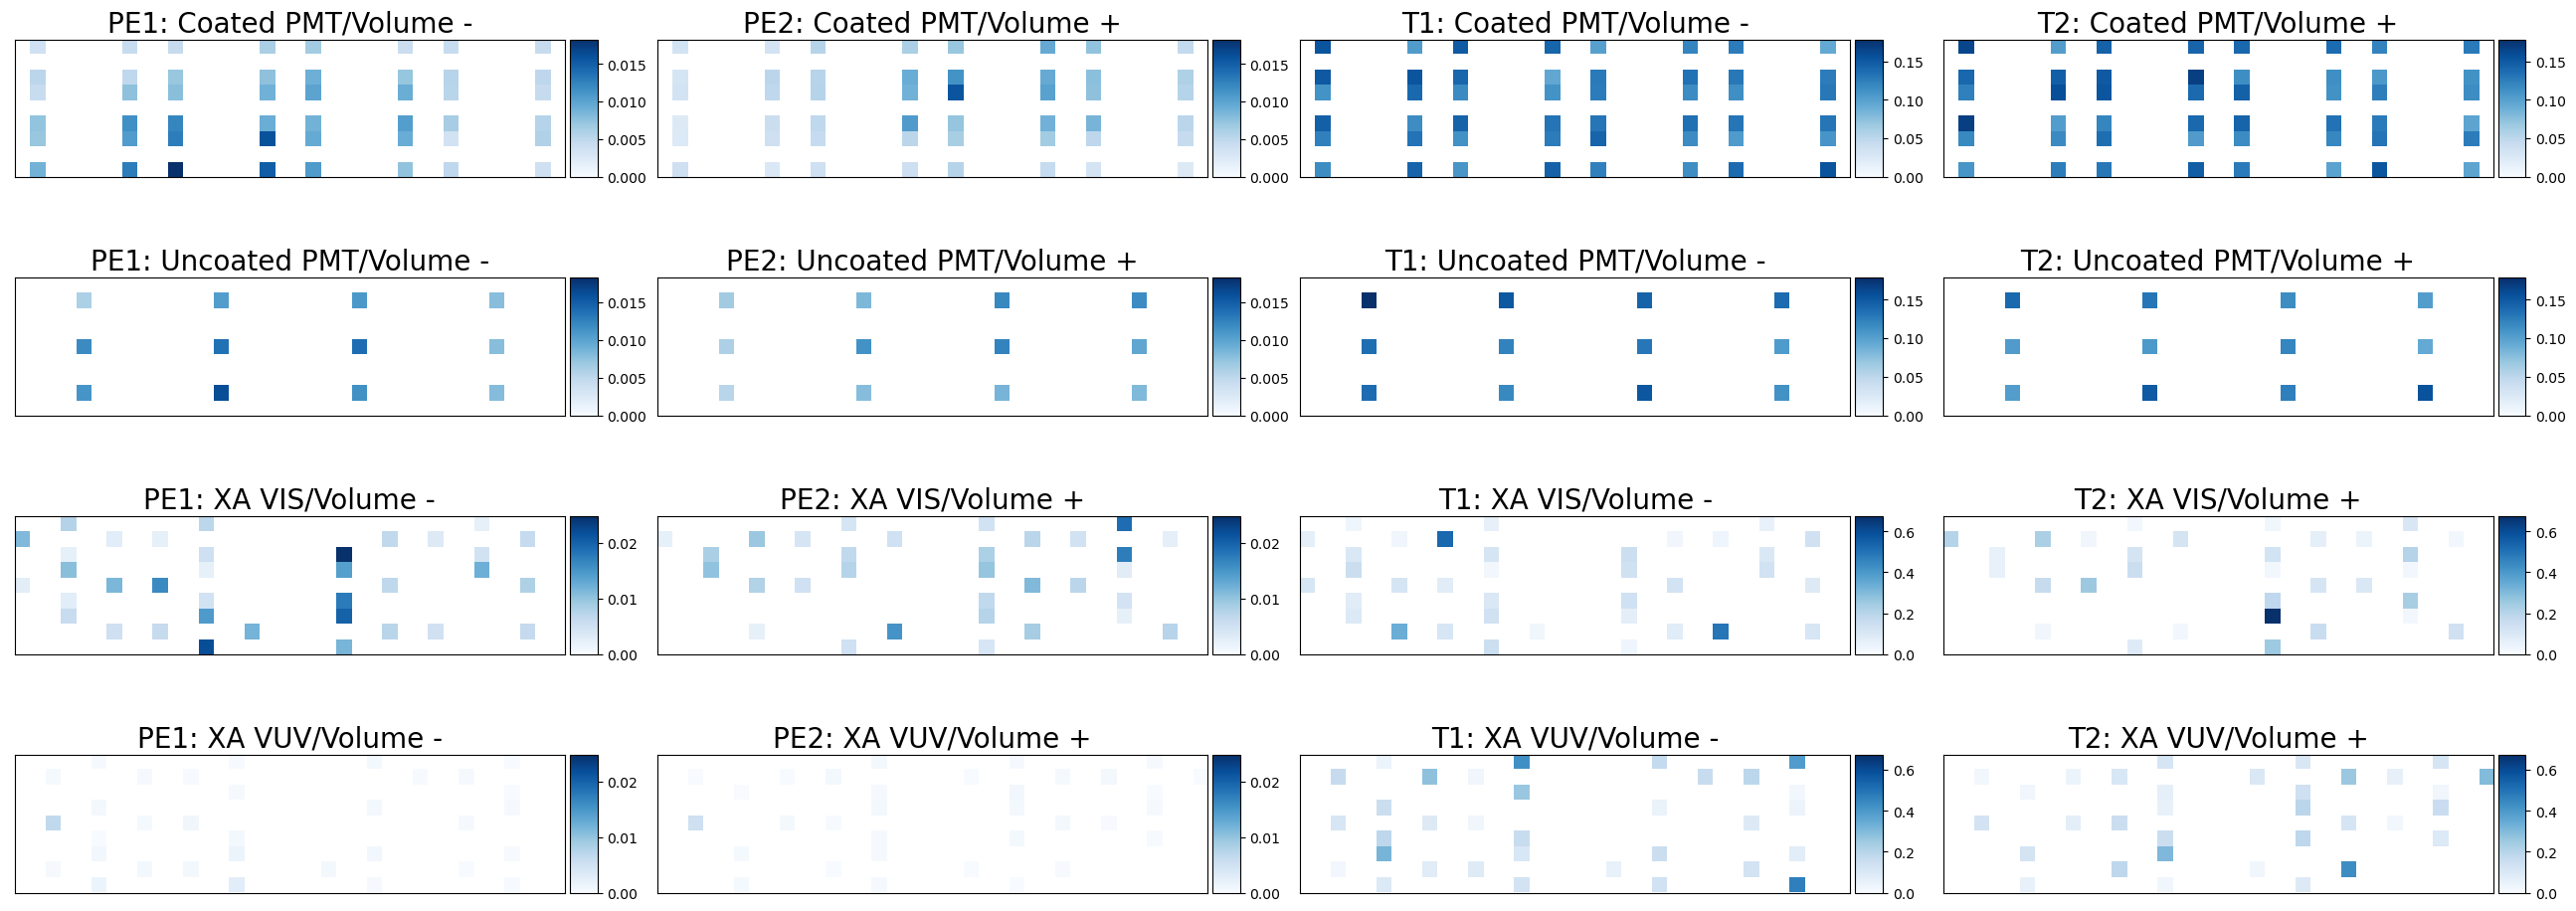

In [13]:
plot_image(image_compressed_4comp, event_idx, labels_4comp, groups_4comp, grid_4comp, figsize=(26, 10),show_colorbar=True)